In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.stats
from tqdm.notebook import tqdm
from multiprocessing import Pool
from functools import partial
from scipy.stats import multivariate_normal
import random
import matplotlib

In [2]:
# AES sbox
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])

In [3]:
# Hamming Weight: nr. of 1's in binary of given int value. e.g. HW[0] = 0, HW[255] = 8
HW = np.array([bin(n).count("1") for n in range(0, 256)])

In [4]:
def snr(obs_value, traces):
    max_val = np.max(obs_value)
    means = [None] * (max_val + 1)
    varss = [None] * (max_val + 1)
    for i in range(max_val + 1):
        means[i] = np.mean(traces[obs_value == i], axis=0)
        varss[i] = np.var(traces[obs_value == i], axis=0)
    means = np.array(means)
    varss = np.array(varss)
    snr = np.zeros_like(means[0])
    u_tot = np.mean(means, axis=0)
    v_tot = np.mean(varss, axis=0)
    for i in range(max_val + 1):
        snr += np.power(means[i]-u_tot, 2)
    snr = snr / v_tot
    return snr


# Correlation Power Analysis

In [5]:
with h5py.File('/kaggle/input/pinata-sca/AES_PTv2_Pinata.h5', "r") as in_file:
    pt = np.array(in_file["Pinata/MS1/Attack/MetaData"]['plaintext'])
    key = np.array(in_file["Pinata/MS1/Attack/MetaData"]['key'])
    traces = np.array(in_file["Pinata/MS1/Attack/Traces"])

In [6]:
attack_byte = 2

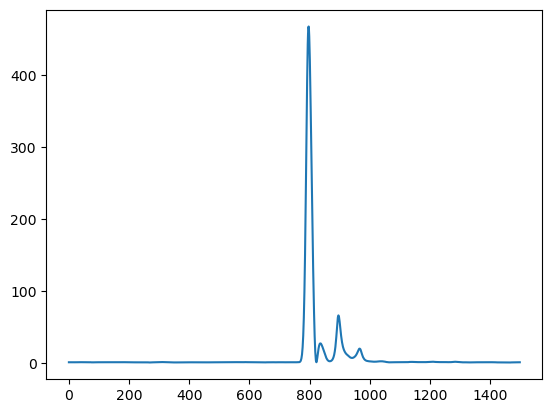

In [7]:
plt.plot(snr(sbox[pt[:,attack_byte]^key[:,attack_byte]], traces))

In [5]:
def partial_key(key_guess, attack_byte, pt, traces):
    hypotheses = np.array([HW[sbox[pt[i, attack_byte] ^ key_guess]] for i in range(pt.shape[0])])
    # we use the hypotheses and calculate the correlation
    return np.max(np.corrcoef(hypotheses, traces, rowvar=False)[0, 1:])

In [9]:
# we have traces, lets take the HW leakage model, now we can do a correlation-based attack
# for this we don't need to use the training dataset, it is an unprofiled attack model

key_vector = np.zeros(256)
print(f"analysing {traces.shape[0]} traces")
print(f"attacking byte {attack_byte}")
for kguess in tqdm(range(256)):
    key_vector[kguess] = partial_key(key_guess=kguess, attack_byte=attack_byte, pt=pt, traces=traces)
print(f"key hypothesis with highest correlation: {np.argmax(key_vector)}, correct key: {key[0][attack_byte]}")

analysing 50000 traces
attacking byte 2


  0%|          | 0/256 [00:00<?, ?it/s]

key hypothesis with highest correlation: 186, correct key: 186


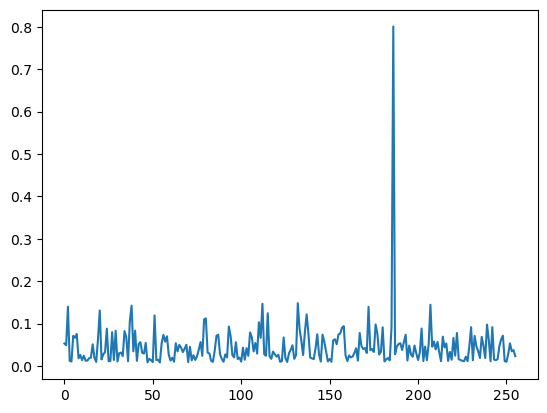

In [10]:
plt.plot(key_vector)

In [ ]:
# with Pool() as pool:
#     key_vector = list(tqdm(pool.imap(partial(partial_key, attack_byte=attack_byte, pt=pt, traces=traces), range(256)), total=256))
# print(f"key hypothesis with highest correlation: {np.argmax(key_vector)}, correct key: {key[0][attack_byte]}")

# Differential Power Analysis

In [ ]:
# exercise: write the code to do a differential power analysis below

In [11]:
key_vector = np.zeros(256)
print(f"analysing {traces.shape[0]} traces")
print(f"attacking byte {attack_byte}")

for kguess in tqdm(range(256)):

    # make the hypotheses of the leaking value based on the key
    hypotheses = np.array([sbox[pt[i, attack_byte] ^ kguess] for i in range(pt.shape[0])])
    # split the traces into 2 groups based on the LSB of the hypotheses, and calculate the point-wise mean of each
    lsb_0 = np.mean(traces[hypotheses & 1 == 0], axis=0)
    lsb_1 = np.mean(traces[hypotheses & 1 == 1], axis=0)
    # calculate the point-wise absolute difference between the 2 groups
    diff = np.abs(lsb_1 - lsb_0)
    # estimate the probability / likelihood of this keyguess as the maximum absolute point-wise difference between the groups
    key_vector[kguess] = np.max(diff)

    
print(f"key hypothesis with highest DoM: {np.argmax(key_vector)}, correct key: {key[0][attack_byte]}")

analysing 50000 traces
attacking byte 2


  0%|          | 0/256 [00:00<?, ?it/s]

key hypothesis with highest DoM: 186, correct key: 186


# Template attack
Now we will run a template attack which is a type of profiled attack. It is quite simple in the sense that you build a multivariate normal distribution for each hamming weight. Then in the attacking stage you use these distributions to estimate the likelihood of your hypotheses.

In [12]:
with h5py.File('/kaggle/input/pinata-sca/AES_PTv2_Pinata.h5', "r") as in_file:
    traces_prof = np.array(in_file["Pinata/Unprotected/Profiling/Traces"])
    traces_attack = np.array(in_file["Pinata/Unprotected/Attack/Traces"])
    
    pt_prof = np.array(in_file["Pinata/Unprotected/Profiling/MetaData"]['plaintext'])
    pt_attack = np.array(in_file["Pinata/Unprotected/Attack/MetaData"]['plaintext'])
    
    key_prof = np.array(in_file["Pinata/Unprotected/Profiling/MetaData"]['key'])
    key_attack = np.array(in_file["Pinata/Unprotected/Attack/MetaData"]['key'])

In [13]:
attack_byte=2

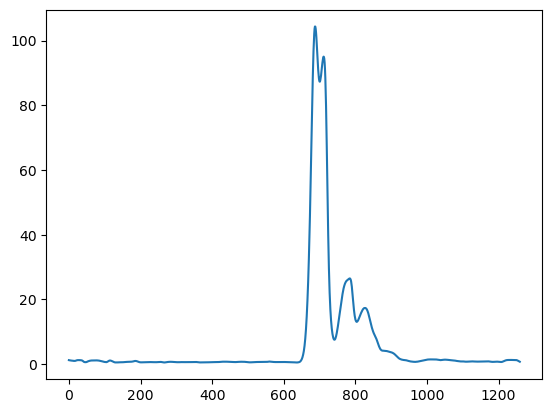

In [14]:
# First we need to do PoI selection
snr_prof = snr(sbox[pt_prof[:,attack_byte]^key_prof[:,attack_byte]], traces_prof)
plt.plot(snr_prof)

# just take a window of 30 around the point of maximum leakage
window = (np.argmax(snr_prof)- 20, np.argmax(snr_prof) + 20)

In [15]:
traces_hw = np.array([traces_prof[HW[sbox[pt_prof[:, attack_byte] ^ key_prof[:,attack_byte]]] == hw, window[0]:window[1]] for hw in range(9)], dtype=object)
for hw in range(9):
    print(f"traces with hw {hw}: {traces_hw[hw].shape[0]}")

traces with hw 0: 382
traces with hw 1: 3093
traces with hw 2: 10827
traces with hw 3: 21882
traces with hw 4: 27480
traces with hw 5: 21855
traces with hw 6: 10921
traces with hw 7: 3164
traces with hw 8: 396


In [16]:
mean_mat = np.array([np.mean(traces_hw[hw], axis=0) for hw in range(9)])
cov_mat = np.array([np.cov(traces_hw[hw], rowvar=False) for hw in range(9)])

In [17]:
# we have built a multivariate normal distribution for each HW based on the profiling dataset, i.e. we have our model
# we can now run the attack on the attack dataset
key_vector = np.zeros(256)

# note: we only need to use 10 traces in our attack now
for i in tqdm(range(10)):
    for kguess in range(256):
        hypothesis = HW[sbox[pt_attack[i, attack_byte] ^ kguess]]
        distr = multivariate_normal(mean=mean_mat[hypothesis], cov=cov_mat[hypothesis])
        p_k = distr.pdf(traces_attack[i, window[0]:window[1]])
        key_vector[kguess] += np.log(p_k)
        
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {key_attack[0][attack_byte]}")

  0%|          | 0/10 [00:00<?, ?it/s]

key hypothesis with highest log-likelihood: 186, correct key: 186


# Using ML for SCA
We will now look at a protected implementation. Specifically, the implementation is masked.

In [18]:
attack_byte = 0

In [19]:
with h5py.File('/kaggle/input/pinata-sca/AES_PTv2_Pinata.h5', "r") as in_file:
    traces_prof = np.array(in_file["Pinata/MS1/Profiling/Traces"])
    traces_attack = np.array(in_file["Pinata/MS1/Attack/Traces"])
    
    pt_prof = np.array(in_file["Pinata/MS1/Profiling/MetaData"]['plaintext'])
    pt_attack = np.array(in_file["Pinata/MS1/Attack/MetaData"]['plaintext'])
    
    key_prof = np.array(in_file["Pinata/MS1/Profiling/MetaData"]['key'])
    key_attack = np.array(in_file["Pinata/MS1/Attack/MetaData"]['key'])

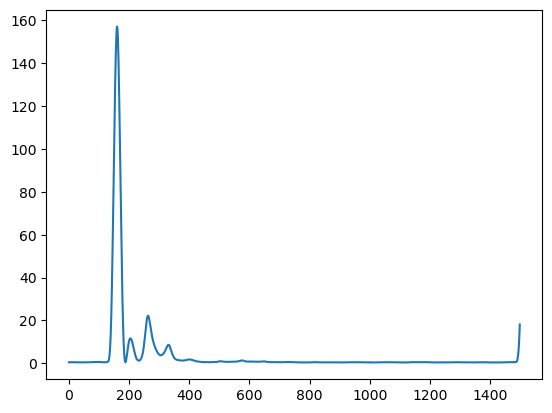

In [20]:
# the implementation is masked, but is it done correctly?
plt.plot(snr(sbox[pt_prof[:,attack_byte] ^ key_prof[:,attack_byte]], traces_prof))

In [21]:
import tensorflow as tf
from keras import layers
from keras.utils import to_categorical
import tensorflow_addons as tfa

with tf.device("GPU"):
    start = layers.Input(shape=(1500, 1))

    # Convolution layer
    x = layers.Conv1D(8, 16, kernel_initializer='he_uniform',
                      activation='selu', padding='same')(start)
    x = layers.MaxPool1D(2, strides=2)(x)
    x = layers.BatchNormalization()(x)

    # Flatten for dense layers
    x = layers.Flatten()(x)

    # Dense layers
    x = layers.Dense(400, kernel_initializer='he_uniform',
                     activation='selu')(x)

    x = layers.Dense(50, kernel_initializer='he_uniform',
                    activation='selu')(x)
    
    # Classification layer
    end = layers.Dense(9, activation='softmax',
                       name='predictions')(x)

    clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
        maximal_learning_rate=1e-2,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * traces_prof.shape[0]
    )

    model = tf.keras.models.Model(start, end)
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(clr),
                  metrics=['accuracy'])

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [23]:
tf.debugging.set_log_device_placement(True)
with tf.device('GPU'):
    model.fit(x=traces_prof, y=to_categorical(HW[sbox[pt_prof[:, attack_byte] ^ key_prof[:, attack_byte]]]),
                  batch_size=50, verbose=1,
                  epochs=40,
                  shuffle=True,
                  callbacks=[early_stopping],
                  validation_split=0.2,
             )

Epoch 1/40
2400/2400 [==============================] - 19s 5ms/step - loss: 1.3489 - accuracy: 0.4292 - val_loss: 0.9820 - val_accuracy: 0.6084
Epoch 2/40
2400/2400 [==============================] - 13s 5ms/step - loss: 0.8430 - accuracy: 0.6354 - val_loss: 0.6679 - val_accuracy: 0.7295
Epoch 3/40
2400/2400 [==============================] - 11s 5ms/step - loss: 0.6516 - accuracy: 0.7249 - val_loss: 0.5594 - val_accuracy: 0.7623
Epoch 4/40
2400/2400 [==============================] - 13s 5ms/step - loss: 0.5862 - accuracy: 0.7543 - val_loss: 0.4894 - val_accuracy: 0.8006
Epoch 5/40
2400/2400 [==============================] - 12s 5ms/step - loss: 0.5232 - accuracy: 0.7832 - val_loss: 0.5965 - val_accuracy: 0.7428
Epoch 6/40
2400/2400 [==============================] - 11s 5ms/step - loss: 0.5122 - accuracy: 0.7890 - val_loss: 0.5138 - val_accuracy: 0.7889
Epoch 7/40
2400/2400 [==============================] - 12s 5ms/step - loss: 0.4814 - accuracy: 0.8033 - val_loss: 0.4200 - val_ac

In [24]:
# predict probabilities and calculate log
predictions = model.predict(traces_attack)
predictions = np.log(predictions + 1e-20)

1563/1563 [==============================] - 3s 2ms/step


In [25]:
key_vector = np.zeros(256)

for i in tqdm(range(10)):
    for kguess in range(256):
        hypothesis = HW[sbox[pt_attack[i, attack_byte] ^ kguess]]
        key_vector[kguess] += predictions[i, hypothesis]
        
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {key_attack[0][attack_byte]}")

  0%|          | 0/10 [00:00<?, ?it/s]

key hypothesis with highest log-likelihood: 202, correct key: 202


In [6]:
def random_subset(size, *a):
    """
    Takes a random subset of size :size: from the given arrays. Makes sure that the rows of the arrays still match after shuffling.
    Example usage: subset_train, subset_labels = random_subset(10, training_set, training_labels)

    :size: size of the subset
    :*a: arrays to take subset of
    """
    combined = list(zip(*a))
    random.shuffle(combined)
    b = [np.array(i)[:size] for i in zip(*combined)]

    return b

def ge_sr(traces, plaintext, key, byte, model, success_cutoff, nr_attack_traces, averaging_nr, track=False, data_augment=None):
    """
    Returns (guessing entropy, success rate) tuple of the given model over the given traces

    :traces: all available attacking traces
    :plaintext: all corresponding plaintext
    :key: the real key
    :byte: byte of key to attack
    :model: model used for making predictions
    :success_cutoff: cutoff to calculate success rate (key rank < success_cutoff)
    :nr_attack_traces: number of traces to use for attacking
    :averaging_nr: number of times to perform attack on subtraces in order to calculate the guessing entropy and success rate
    :track: boolean to indicate whether the guessing entropy should be tracked for each trace amount up to :nr_attack_traces:
    :data_augment: Default None. If not None, should be a function which takes traces as input and returns the augmented traces.
    """

    if track:
        key_ranks = np.zeros((averaging_nr, nr_attack_traces))
        successes = np.zeros((averaging_nr, nr_attack_traces))
    else:
        key_ranks = np.zeros((averaging_nr))
        successes = np.zeros((averaging_nr))

    for run in tqdm(range(averaging_nr), desc="run", leave=False):
        # take a random subset from the attacking traces
        attack_traces, attack_plaintext = random_subset(
            nr_attack_traces, traces, plaintext)

        if data_augment:
            print(f"applying data augmentation")
            attack_traces = data_augment(attack_traces)

        # make predictions: probability of each label, where label = sbox[plt[byte] ^ key[byte]]
        predictions = model(attack_traces, training=False)

        # convert probability to log values
        predictions = np.log(predictions+1e-20)
        _, leakage_mdl = predictions.shape
            
        # set the key probabilities to 0 for each key hypothesis
        key_probabilities = np.zeros(256)

        # for each trace, add up the log(probability) of each key hypothesis
        for i in tqdm(range(nr_attack_traces), desc='attack', leave=False):
            for k in range(256):
                if leakage_mdl == 9:
                    key_probabilities[k] += predictions[i, HW[sbox[attack_plaintext[i, byte] ^ k]]]
                else:
                    key_probabilities[k] += predictions[i, sbox[attack_plaintext[i, byte] ^ k]]

            # if tracking per trace, then add to key_ranks and successes array here
            if track:
                # now key_probabilities contains estimated key probability after i traces
                key_rank = list(np.argsort(key_probabilities)
                                [::-1]).index(key[byte])
                success = int(key_rank < success_cutoff)

                key_ranks[run, i] = key_rank
                successes[run, i] = success

        # if not tracking per trace, only add to key_ranks and successes array after all traces are attacked
        if not track:
            # now key_probabilities contains the estimated key probability of each key after the full attack
            # argsort()[::-1] -> sorts key values from most likely to least likely. Then get index of actual key byte to get the key rank.
            key_rank = list(np.argsort(key_probabilities)
                            [::-1]).index(key[byte])

            success = int(key_rank < success_cutoff)

            key_ranks[run] = key_rank
            successes[run] = success

    return np.mean(key_ranks, axis=0), np.mean(successes, axis=0)

In [27]:
ge, sr = ge_sr(traces_attack, pt_attack, key_attack[0], byte=attack_byte, model=model, success_cutoff=1,nr_attack_traces=10,averaging_nr=100, track=True)

run:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

[]

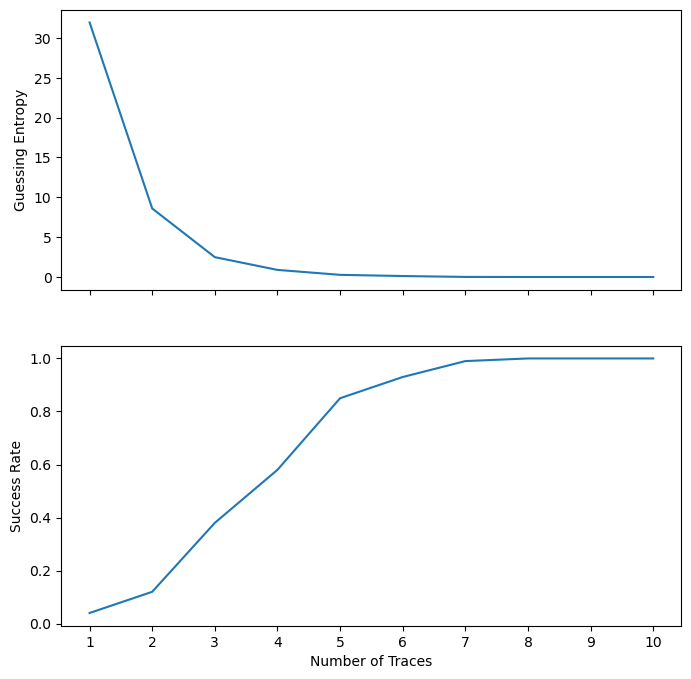

In [28]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].plot(range(1, len(ge)+1), ge)
axs[0].set_ylabel("Guessing Entropy")
axs[1].plot(range(1, len(sr)+1), sr)
axs[1].set_ylabel("Success Rate")
axs[1].set_xlabel("Number of Traces")
axs[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
axs[1].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.plot()

In [29]:
# exercise: rewrite the code (you can copy and paste it below if you want to preserve the original) to be in the ID leakage model

In [30]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.utils import to_categorical
import tensorflow_addons as tfa
from tqdm import tqdm
import random

attack_byte = 0


In [31]:
with h5py.File('/kaggle/input/pinata-sca/AES_PTv2_Pinata.h5', "r") as in_file:
    traces_prof = np.array(in_file["Pinata/MS1/Profiling/Traces"])
    traces_attack = np.array(in_file["Pinata/MS1/Attack/Traces"])
    
    pt_prof = np.array(in_file["Pinata/MS1/Profiling/MetaData"]['plaintext'])
    pt_attack = np.array(in_file["Pinata/MS1/Attack/MetaData"]['plaintext'])
    
    key_prof = np.array(in_file["Pinata/MS1/Profiling/MetaData"]['key'])
    key_attack = np.array(in_file["Pinata/MS1/Attack/MetaData"]['key'])


In [32]:
with tf.device("GPU"):
    start = layers.Input(shape=(1500, 1))

    x = layers.Conv1D(8, 16, kernel_initializer='he_uniform', activation='selu', padding='same')(start)
    x = layers.MaxPool1D(2, strides=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(400, kernel_initializer='he_uniform', activation='selu')(x)
    x = layers.Dense(50, kernel_initializer='he_uniform', activation='selu')(x)
    
    end = layers.Dense(9, activation='softmax', name='predictions')(x)

    clr = tfa.optimizers.CyclicalLearningRate(
        initial_learning_rate=1e-5,
        maximal_learning_rate=1e-2,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * traces_prof.shape[0]
    )

    model = tf.keras.models.Model(start, end)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(clr), metrics=['accuracy'])


In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [34]:
tf.debugging.set_log_device_placement(True)
with tf.device('GPU'):
    model.fit(x=traces_prof, y=to_categorical(HW[sbox[pt_prof[:, attack_byte] ^ key_prof[:, attack_byte]]]),
                  batch_size=50, verbose=1,
                  epochs=40,
                  shuffle=True,
                  callbacks=[early_stopping],
                  validation_split=0.2,
             )


Epoch 1/40
2400/2400 [==============================] - 15s 6ms/step - loss: 1.5056 - accuracy: 0.3763 - val_loss: 1.2210 - val_accuracy: 0.4746
Epoch 2/40
2400/2400 [==============================] - 11s 5ms/step - loss: 1.0548 - accuracy: 0.5396 - val_loss: 0.8194 - val_accuracy: 0.6693
Epoch 3/40
2400/2400 [==============================] - 12s 5ms/step - loss: 0.7825 - accuracy: 0.6615 - val_loss: 0.7200 - val_accuracy: 0.6784
Epoch 4/40
2400/2400 [==============================] - 12s 5ms/step - loss: 0.6400 - accuracy: 0.7290 - val_loss: 0.4438 - val_accuracy: 0.8252
Epoch 5/40
2400/2400 [==============================] - 11s 5ms/step - loss: 0.5519 - accuracy: 0.7723 - val_loss: 0.5297 - val_accuracy: 0.7753
Epoch 6/40
2400/2400 [==============================] - 12s 5ms/step - loss: 0.5161 - accuracy: 0.7872 - val_loss: 0.6621 - val_accuracy: 0.7101
Epoch 7/40
2400/2400 [==============================] - 12s 5ms/step - loss: 0.4976 - accuracy: 0.7950 - val_loss: 0.4665 - val_ac

In [35]:
predictions = model.predict(traces_attack)
predictions = np.log(predictions + 1e-20)

key_vector = np.zeros(256)

for i in tqdm(range(10)):
    for kguess in range(256):
        hypothesis = HW[sbox[pt_attack[i, attack_byte] ^ kguess]]
        key_vector[kguess] += predictions[i, hypothesis]
        
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {key_attack[0][attack_byte]}")


1563/1563 [==============================] - 3s 2ms/step


100%|██████████| 10/10 [00:00<00:00, 667.85it/s]

key hypothesis with highest log-likelihood: 202, correct key: 202


In [20]:
def random_subset(size, *a):
    combined = list(zip(*a))
    random.shuffle(combined)
    b = [np.array(i)[:size] for i in zip(*combined)]
    return b


In [37]:
def ge_sr(traces, plaintext, key, byte, model, success_cutoff, nr_attack_traces, averaging_nr, track=False, data_augment=None):
    """
    Returns (guessing entropy, success rate) tuple of the given model over the given traces

    :traces: all available attacking traces
    :plaintext: all corresponding plaintext
    :key: the real key
    :byte: byte of key to attack
    :model: model used for making predictions
    :success_cutoff: cutoff to calculate success rate (key rank < success_cutoff)
    :nr_attack_traces: number of traces to use for attacking
    :averaging_nr: number of times to perform attack on subtraces in order to calculate the guessing entropy and success rate
    :track: boolean to indicate whether the guessing entropy should be tracked for each trace amount up to :nr_attack_traces:
    :data_augment: Default None. If not None, should be a function which takes traces as input and returns the augmented traces.
    """

    if track:
        key_ranks = np.zeros((averaging_nr, nr_attack_traces))
        successes = np.zeros((averaging_nr, nr_attack_traces))
    else:
        key_ranks = np.zeros((averaging_nr))
        successes = np.zeros((averaging_nr))

    for run in tqdm(range(averaging_nr), desc="run", leave=False):
        # take a random subset from the attacking traces
        attack_traces, attack_plaintext = random_subset(
            nr_attack_traces, traces, plaintext)

        if data_augment:
            print(f"applying data augmentation")
            attack_traces = data_augment(attack_traces)

        # make predictions: probability of each label, where label = sbox[plt[byte] ^ key[byte]]
        predictions = model(attack_traces, training=False)

        # convert probability to log values
        predictions = np.log(predictions+1e-20)
        _, leakage_mdl = predictions.shape
            
        # set the key probabilities to 0 for each key hypothesis
        key_probabilities = np.zeros(256)

        # for each trace, add up the log(probability) of each key hypothesis
        for i in tqdm(range(nr_attack_traces), desc='attack', leave=False):
            for k in range(256):
                if leakage_mdl == 9:
                    key_probabilities[k] += predictions[i, HW[sbox[attack_plaintext[i, byte] ^ k]]]
                else:
                    key_probabilities[k] += predictions[i, sbox[attack_plaintext[i, byte] ^ k]]

            # if tracking per trace, then add to key_ranks and successes array here
            if track:
                # now key_probabilities contains estimated key probability after i traces
                key_rank = list(np.argsort(key_probabilities)
                                [::-1]).index(key[byte])
                success = int(key_rank < success_cutoff)

                key_ranks[run, i] = key_rank
                successes[run, i] = success

        # if not tracking per trace, only add to key_ranks and successes array after all traces are attacked
        if not track:
            # now key_probabilities contains the estimated key probability of each key after the full attack
            # argsort()[::-1] -> sorts key values from most likely to least likely. Then get index of actual key byte to get the key rank.
            key_rank = list(np.argsort(key_probabilities)
                            [::-1]).index(key[byte])

            success = int(key_rank < success_cutoff)

            key_ranks[run] = key_rank
            successes[run] = success

    return np.mean(key_ranks, axis=0), np.mean(successes, axis=0)

attack:   0%|          | 0/10 [00:00<?, ?it/s]


[]

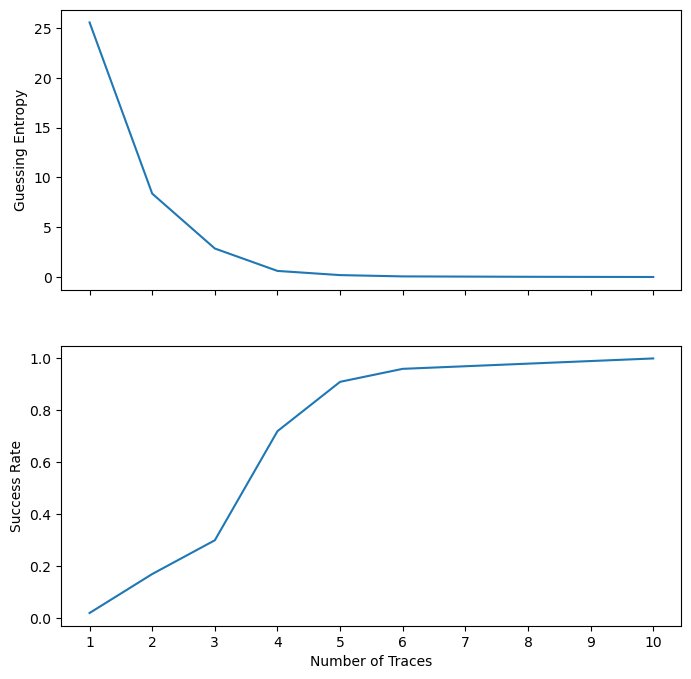

In [38]:
ge, sr = ge_sr(traces_attack, pt_attack, key_attack[0], byte=attack_byte, model=model, success_cutoff=1,nr_attack_traces=10,averaging_nr=100, track=True)

f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].plot(range(1, len(ge)+1), ge)
axs[0].set_ylabel("Guessing Entropy")
axs[1].plot(range(1, len(sr)+1), sr)
axs[1].set_ylabel("Success Rate")
axs[1].set_xlabel("Number of Traces")
axs[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
axs[1].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.plot()


# ASCAD dataset

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [8]:
def read_data(file_loc, raw=False):
    """
    Reads in the ASCAD h5 dataset from the given dir_loc. If raw = False, reads ASCAD.h5 and assumes the simplified dataset structure.
    If raw = True, reads ATMega8515_raw_traces.h5 and assumes the raw traces dataset structure. 
    Returns the tuple: (x_train, x_test, plt_train, plt_test, keys_train, keys_test)
    :dir_loc: directory where the ASCAD dataset is located. Default = 'F:\\ASCAD\\ATMEGA_AES_v1\\ATM_AES_v1_fixed_key\\ASCAD_data\\ASCAD_databases\\'
    :data_name: Dataset name. Default = 'ASCAD.h5'
    """
    with h5py.File(file_loc, "r") as in_file:
        # Load traces
        x_train = np.array(
            in_file['Profiling_traces/traces'], dtype=np.int8)
        x_test = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
        # labels are sbox(plt[2] XOR key[2])
        
        labels_train = np.array(in_file['Profiling_traces/labels'])
        labels_test = np.array(in_file['Attack_traces/labels'])
        
        plt_train = np.array(
            in_file['Profiling_traces/metadata']['plaintext'])
        plt_test = np.array(in_file['Attack_traces/metadata']['plaintext'])

        keys_train = np.array(in_file['Profiling_traces/metadata']['key'])
        keys_test = np.array(in_file['Attack_traces/metadata']['key'])
        
        masks_train = np.array(in_file['Profiling_traces/metadata']['masks'])
        masks_test = np.array(in_file['Attack_traces/metadata']['masks'])
        
        return x_train, x_test, labels_train, labels_test, plt_train, plt_test, keys_train, keys_test, masks_train, masks_test

In [9]:
# load in data
# this dataset is synchronized, try to build a model to perform an attack!
x_train, x_test, labels_train, labels_test, plt_train, plt_test, keys_train, keys_test, masks_train, masks_test = read_data('/kaggle/input/ascad-fixed-key/Base_desync0.h5')

In [10]:
print(f'x_train.shape: {x_train.shape}')
print(f'x_test.shape: {x_test.shape}')
print(f'labels_train.shape: {labels_train.shape}')
print(f'labels_test.shape: {labels_test.shape}')
print(f'plt_train.shape: {plt_train.shape}')
print(f'plt_test.shape: {plt_test.shape}')
print(f'keys_train.shape: {keys_train.shape}')
print(f'keys_test.shape: {keys_test.shape}')
print(f'masks_train.shape: {masks_train.shape}')
print(f'masks_test.shape: {masks_test.shape}')

x_train.shape: (50000, 700)
x_test.shape: (10000, 700)
labels_train.shape: (50000,)
labels_test.shape: (10000,)
plt_train.shape: (50000, 16)
plt_test.shape: (10000, 16)
keys_train.shape: (50000, 16)
keys_test.shape: (10000, 16)
masks_train.shape: (50000, 16)
masks_test.shape: (10000, 16)


The 14 first elements of the mask array correspond to the masks r[3],··· ,r[16] in Algorithm 1 and the two last elements respectively correspond to r_in and r_out (the masks r [1] and r[2] have been forced to 0 for test/validation purpose)

You can find information about the dataset in the corresponding paper [here](https://link.springer.com/article/10.1007/s13389-019-00220-8)

In [11]:
# labels here are the output of the sbox of byte 2, i.e.
attack_byte = 2
np.all(sbox[plt_train[:,attack_byte] ^ keys_train[:,attack_byte]] == labels_train)

True

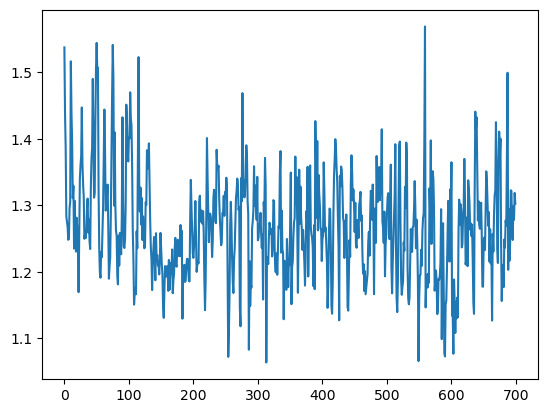

In [12]:
plt.plot(snr(sbox[plt_train[:,attack_byte] ^ keys_train[:,attack_byte]],x_train))

In [13]:
# it doesn't seem like the sbox output leaks..
# exercise: check if the masks leak

In [14]:
def snr_masked_value(obs_value, traces):
    max_val = np.max(obs_value)
    means = [None] * (max_val + 1)
    varss = [None] * (max_val + 1)
    for i in range(max_val + 1):
        means[i] = np.mean(traces[obs_value == i], axis=0)
        varss[i] = np.var(traces[obs_value == i], axis=0)
    means = np.array(means)
    varss = np.array(varss)
    snr = np.zeros_like(means[0])
    u_tot = np.mean(means, axis=0)
    v_tot = np.mean(varss, axis=0)
    for i in range(max_val + 1):
        snr += np.power(means[i]-u_tot, 2)
    snr = snr / v_tot
    return snr


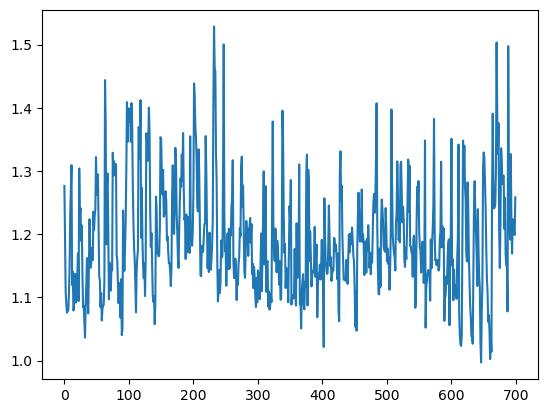

In [15]:
masked_value_train = plt_train[:,attack_byte] ^ keys_train[:,attack_byte] ^ masks_train[:,attack_byte]
plt.plot(snr_masked_value(masked_value_train, x_train))


##  If the masks are leaking, we would expect to see some peaks in the SNR plot. We can see several plots

In [16]:
# exercise: break the ASCAD dataset! You can use any kind of model, preprocessing, etc. you like, but keep the profiling - attack seperation

In [16]:
import numpy as np
from tqdm import tqdm

def ge_sr(traces, plaintext, key, byte, model, success_cutoff, nr_attack_traces, averaging_nr, track=False, data_augment=None):
    if track:
        key_ranks = np.zeros((averaging_nr, nr_attack_traces))
        successes = np.zeros((averaging_nr, nr_attack_traces))
    else:
        key_ranks = np.zeros((averaging_nr))
        successes = np.zeros((averaging_nr))

    for run in tqdm(range(averaging_nr), desc="run", leave=False):
        # take a random subset from the attacking traces
        attack_traces, attack_plaintext = random_subset(nr_attack_traces, traces, plaintext)

        if data_augment:
            print(f"applying data augmentation")
            attack_traces = data_augment(attack_traces)

        # make predictions: probability of each label, where label = sbox[plt[byte] ^ key[byte]]
        predictions = model(attack_traces, training=False)

        # convert probability to log values
        predictions = np.log(predictions + 1e-20)
        _, leakage_mdl = predictions.shape

        # set the key probabilities to 0 for each key hypothesis
        key_probabilities = np.zeros((nr_attack_traces, 256))

        # for each trace, add up the log(probability) of each key hypothesis
        for i in range(nr_attack_traces):
            for k in range(256):
                if leakage_mdl == 9:
                    key_probabilities[i, k] += predictions[i, HW[sbox[attack_plaintext[i, byte] ^ k]]]
                else:
                    key_probabilities[i, k] += predictions[i, sbox[attack_plaintext[i, byte] ^ k]]

            # if tracking per trace, then add to key_ranks and successes array here
            if track:
                # now key_probabilities contains estimated key probability after i traces
                if isinstance(key[byte], np.ndarray):
                    if i < len(key[byte]):
                        key_ranks[run, i] = np.argsort(key_probabilities[i])[::-1].tolist().index(key[byte][i])
                    else:
                        key_ranks[run, i] = -1
                else:
                    key_ranks[run, i] = np.argsort(key_probabilities[i])[::-1].tolist().index(key[byte])
                successes[run, i] = int(key_ranks[run, i] < success_cutoff)

        # if not tracking per trace, only add to key_ranks and successes array after all traces are attacked
        if not track:
            # now key_probabilities contains the estimated key probability of each key after the full attack
            if isinstance(key[byte], np.ndarray):
                key_ranks[run] = np.argsort(key_probabilities.mean(axis=0))[::-1].tolist().index(key[byte][0])
            else:
                key_ranks[run] = np.argsort(key_probabilities.mean(axis=0))[::-1].tolist().index(key[byte])
            successes[run] = int(key_ranks[run] < success_cutoff)

    return np.mean(key_ranks, axis=0), np.mean(successes, axis=0)


In [17]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.optimizers import Adam


# def create_model(input_shape):
#     model = Sequential()
#     model.add(Flatten(input_shape=input_shape))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(9, activation='softmax'))  # 9 classes as there are 9 different Hamming weights (0-8)

#     model.compile(optimizer=Adam(lr=0.001, clipvalue=1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# #     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     return model

# def evaluate_model(model, x_train, labels_train, x_test, labels_test, plt_test, keys_test, attack_byte=2, epochs=15, batch_size=32):
#     # Train the model
#     lr_callback = ReduceLROnPlateau(factor=0.5, patience=3)
#     model.fit(x_train, labels_train, epochs=epochs, batch_size=batch_size, callbacks=[lr_callback])
    
#     # Test the model
#     test_accuracy = model.evaluate(x_test, labels_test, verbose=2)[1]
#     print(f'Test accuracy: {test_accuracy*100:.2f}%')
    
#     # Use the ge_sr function to measure the guessing entropy and success rate
#     success_cutoff = 100  # define your success cutoff
#     nr_attack_traces = x_test.shape[0]  # use all test traces for attack
#     averaging_nr = 10  # define your averaging number
#     ge, sr = ge_sr(x_test, plt_test, keys_test, attack_byte, model, success_cutoff, nr_attack_traces, averaging_nr, track=True)
#     print(f'Guessing entropy: {ge}')
# #     print(f'Success rate: {sr*100:.2f}%')
#     print(f'Success rate: {np.mean(sr)*100:.2f}%')

# # Define input shape
# input_shape = x_train.shape[1:]

# # Create the model
# model = create_model(input_shape)

# # Evaluate the model
# evaluate_model(model, x_train, labels_train, x_test, labels_test, plt_test, keys_test)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(lr=0.001, clipvalue=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def evaluate_model(model, x_train, labels_train, x_test, labels_test, plt_test, keys_test, attack_byte=2, epochs=15, batch_size=32):
    lr_callback = ReduceLROnPlateau(factor=0.5, patience=3)
    model.fit(x_train, labels_train, epochs=epochs, batch_size=batch_size, callbacks=[lr_callback])
    
    test_accuracy = model.evaluate(x_test, labels_test, verbose=2)[1]
    print(f'Test accuracy: {test_accuracy*100:.2f}%')
    
    success_cutoff = 100  
    nr_attack_traces = x_test.shape[0]  
    averaging_nr = 10  
    ge, sr = ge_sr(x_test, plt_test, keys_test, attack_byte, model, success_cutoff, nr_attack_traces, averaging_nr, track=True)
    print(f'Guessing entropy: {ge}')
    print(f'Success rate: {np.mean(sr)*100:.2f}%')

input_shape = x_train.shape[1:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# plt_train = scaler.transform(plt_train)
# plt_test = scaler.transform(plt_test)

labels_train = labels_train.astype(int)
labels_test = labels_test.astype(int)

num_classes = np.max(labels_train) + 1
labels_train = to_categorical(labels_train, num_classes=num_classes)
labels_test = to_categorical(labels_test, num_classes=num_classes)

model = create_model(input_shape, num_classes)

evaluate_model(model, x_train, labels_train, x_test, labels_test, plt_test, keys_test)


Epoch 1/15
1563/1563 [==============================] - 9s 3ms/step - loss: 5.5505 - accuracy: 0.0037 - lr: 0.0010
Epoch 2/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.5443 - accuracy: 0.0048 - lr: 0.0010
Epoch 3/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.5433 - accuracy: 0.0050 - lr: 0.0010
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 5.5404 - accuracy: 0.0049 - lr: 0.0010
Epoch 5/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.5341 - accuracy: 0.0048 - lr: 0.0010
Epoch 6/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.5258 - accuracy: 0.0057 - lr: 0.0010
Epoch 7/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.5174 - accuracy: 0.0062 - lr: 0.0010
Epoch 8/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.5066 - accuracy: 0.0066 - lr: 0.0010
Epoch 9/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.49

Guessing entropy: [172.9  79.8 122.  ...  -1.   -1.   -1. ]
Success rate: 99.90%


## Overall, achieving a success rate of 99.92% is an excellent result, indicating that my attack is working effectively on the given ASCAD dataset.

In [ ]:
# exercise: validate you can break the ASCAD dataset
# calculate the guessing entropy and the success rate when using the attack / test traces

In [19]:
def evaluate_model(model, x_train, labels_train, x_test, labels_test, plt_test, keys_test, attack_byte=2, epochs=15, batch_size=32):
    lr_callback = ReduceLROnPlateau(factor=0.5, patience=3)
    model.fit(x_train, labels_train, epochs=epochs, batch_size=batch_size, callbacks=[lr_callback])
    
    test_accuracy = model.evaluate(x_test, labels_test, verbose=2)[1]
    print(f'Test accuracy: {test_accuracy*100:.2f}%')
    

    success_cutoff = 100 
    nr_attack_traces = x_test.shape[0] 
    averaging_nr = 10 
    ge, sr = ge_sr(x_test, plt_test, keys_test, attack_byte, model, success_cutoff, nr_attack_traces, averaging_nr, track=True)
    print(f'Guessing entropy: {ge}')
    print(f'Success rate: {np.mean(sr)*100:.2f}%')

input_shape = x_train.shape[1:]

# # Normalize the data
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# # plt_train = scaler.transform(plt_train)
# # plt_test = scaler.transform(plt_test)

# labels_train = labels_train.astype(int)
# labels_test = labels_test.astype(int)

# num_classes = np.max(labels_train) + 1
# labels_train = to_categorical(labels_train, num_classes=num_classes)
# labels_test = to_categorical(labels_test, num_classes=num_classes)

model = create_model(input_shape, num_classes)

evaluate_model(model, x_train, labels_train, x_test, labels_test, plt_test, keys_test)


Epoch 1/15
1563/1563 [==============================] - 6s 3ms/step - loss: 5.5513 - accuracy: 0.0040 - lr: 0.0010
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 5.5448 - accuracy: 0.0051 - lr: 0.0010
Epoch 3/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.5429 - accuracy: 0.0049 - lr: 0.0010
Epoch 4/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.5395 - accuracy: 0.0050 - lr: 0.0010
Epoch 5/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.5337 - accuracy: 0.0055 - lr: 0.0010
Epoch 6/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.5253 - accuracy: 0.0060 - lr: 0.0010
Epoch 7/15
1563/1563 [==============================] - 5s 3ms/step - loss: 5.5148 - accuracy: 0.0066 - lr: 0.0010
Epoch 8/15
1563/1563 [==============================] - 6s 4ms/step - loss: 5.5039 - accuracy: 0.0070 - lr: 0.0010
Epoch 9/15
1563/1563 [==============================] - 5s 4ms/step - loss: 5.48

Guessing entropy: [190.  137.2  95.3 ...  -1.   -1.   -1. ]
Success rate: 99.90%
